# air quality predictor

## dependencies

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier

import joblib

## dataset

In [2]:
data = pd.read_csv("/content/air.csv")
data.head(10)

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
5,39.4,96.6,14.6,35.5,42.9,17.9,1.82,3.1,674,Hazardous
6,41.7,82.5,1.7,15.8,31.1,12.7,1.80,4.6,735,Poor
7,31.0,59.6,5.0,16.8,24.2,13.6,1.38,6.3,443,Moderate
8,29.4,93.8,10.3,22.7,45.1,11.8,2.03,5.4,486,Poor
9,33.2,80.5,11.1,24.4,32.0,15.3,1.69,4.9,535,Poor


In [3]:
data.shape

(5000, 10)

## simple exploratory dataset analysis

In [4]:
# info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [5]:
# checking for missing values
data.isnull().sum()

,0
Temperature,0
Humidity,0
PM2.5,0
PM10,0
NO2,0
SO2,0
CO,0
Proximity_to_Industrial_Areas,0
Population_Density,0
Air Quality,0


In [6]:
# duplicates
data.duplicated().sum()

np.int64(0)

In [7]:
# statistical description
data.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


In [8]:
# air quality classes
data["Air Quality"].value_counts()

,count
Air Quality,
Good,2000
Moderate,1500
Poor,1000
Hazardous,500


In [9]:
features = data.drop("Air Quality", axis=1)
features = features.columns.tolist()
features

['Temperature',
 'Humidity',
 'PM2.5',
 'PM10',
 'NO2',
 'SO2',
 'CO',
 'Proximity_to_Industrial_Areas',
 'Population_Density']

In [10]:
# detecting outliers using the 1qr method function
def detect_outlier(data, features, multiplier=1.5):
  summary = []
  outlier_indices = set()

  for feature in features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    # outlier indieces
    outliers = data[
        (data[feature] < lower_bound) | (data[feature] > upper_bound)
    ]
    outlier_indices.update(outliers)

    # outliers summary
    summary.append({
        "Feature": feature,
        "Outlier_Count": len(outliers),
        "Percentage": round(
            (len(outliers) / len(data)) * 100, 2
        )
    })

  # summary dataframe
  outlier_summary = pd.DataFrame(summary).sort_values(
      by = "Outlier_Count",
      ascending = False
  )

  return outlier_summary


In [11]:
# outliers
summary = detect_outlier(data, features)
summary

,Feature,Outlier_Count,Percentage
2,PM2.5,352,7.04
3,PM10,324,6.48
5,SO2,124,2.48
4,NO2,73,1.46
0,Temperature,72,1.44
6,CO,45,0.90
1,Humidity,19,0.38
7,Proximity_to_Industrial_Areas,16,0.32
8,Population_Density,7,0.14


## insights:
  - neither duplicates nor missing values
  - imbalances classes
  - only classes are in objects dtype (encode during preprocessing)

## exploratory data analysis visualizer

In [13]:
sns.set(style="whitegrid")

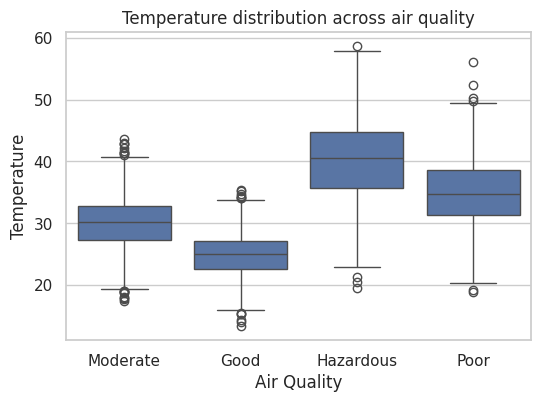

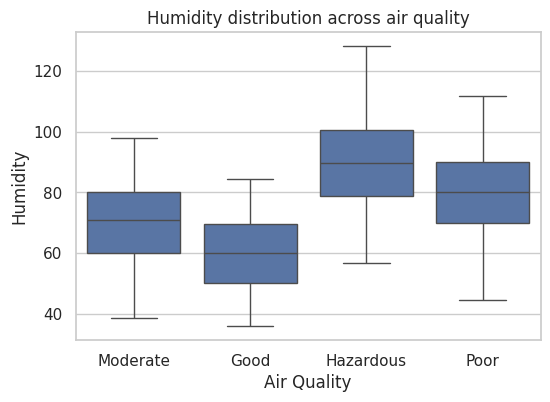

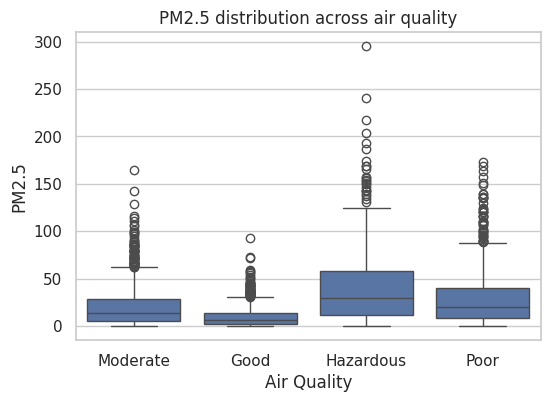

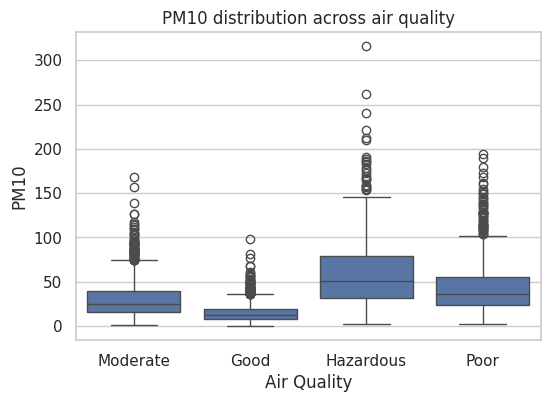

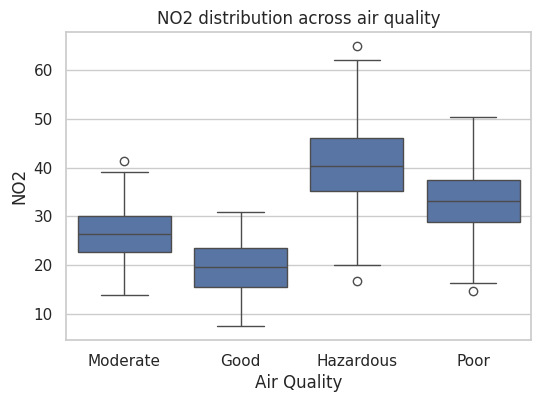

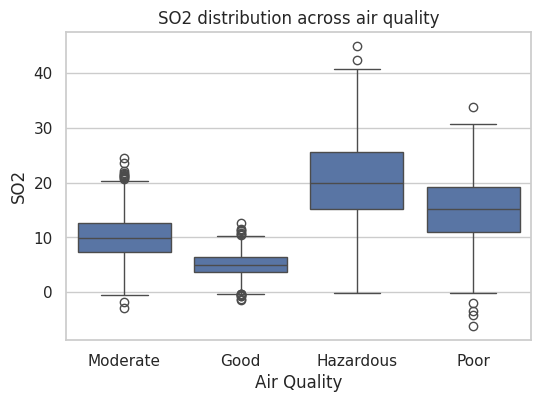

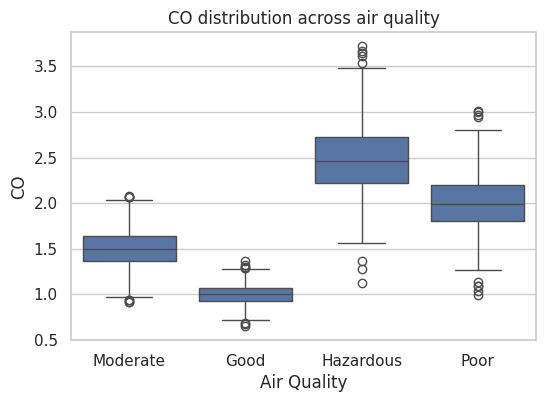

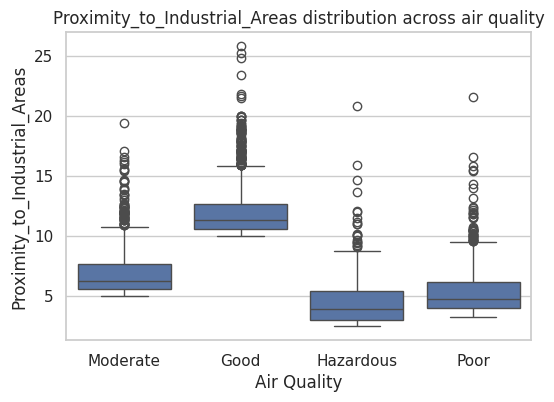

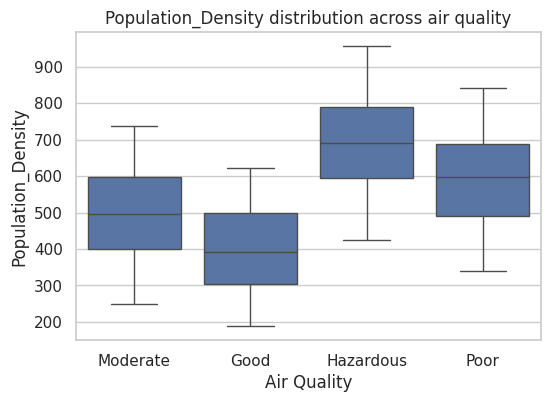

In [14]:
# boxplots of features distribution across air quality classes
for feature in features:
  plt.figure(figsize=(6, 4))
  sns.boxplot(
      x = "Air Quality",
      y = feature,
      data = data
  )
  plt.title(f"{feature} distribution across air quality")
  plt.show()



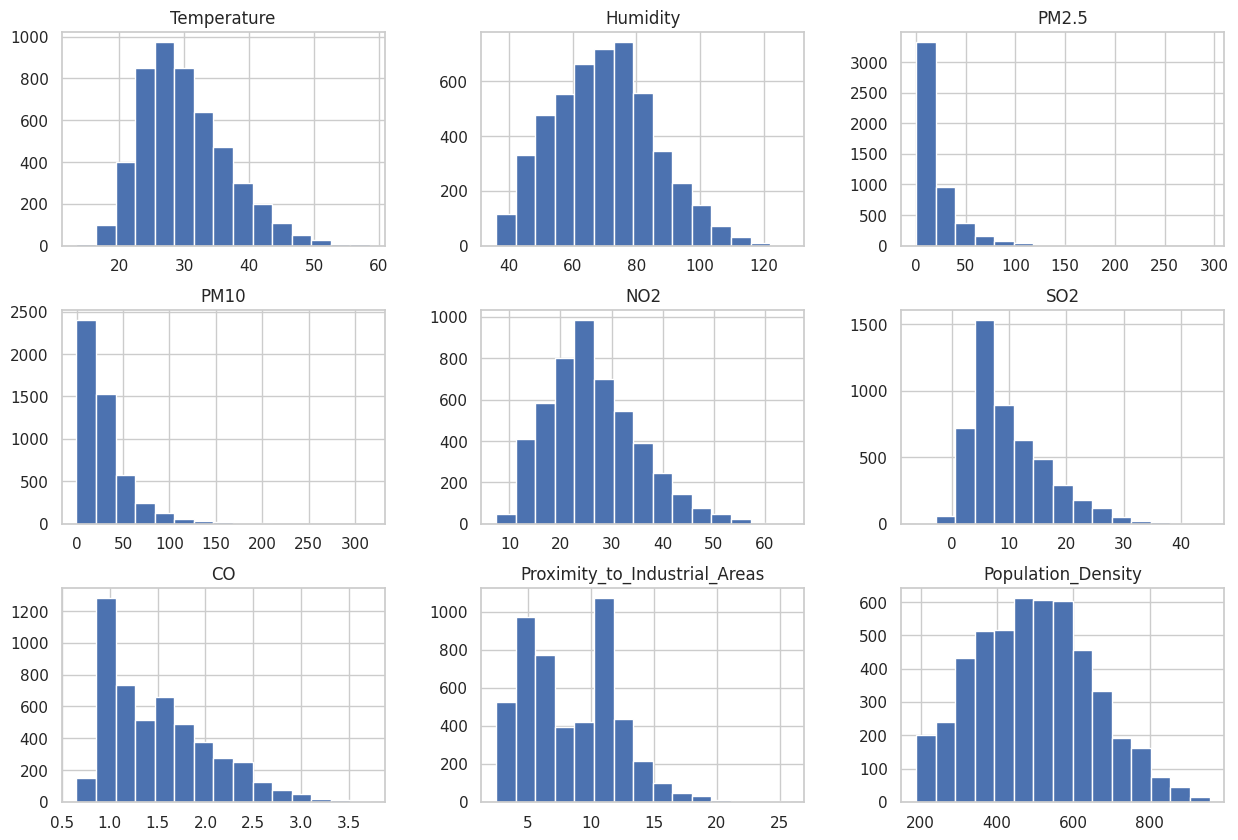

In [15]:
# histograms
data[features].hist(figsize=(15, 10), bins=15)
plt.show()

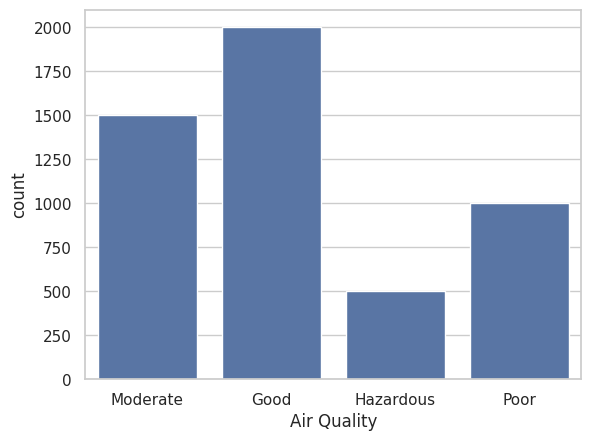

In [17]:
# countplots for gender
sns.countplot(x="Air Quality", data=data)
plt.show()

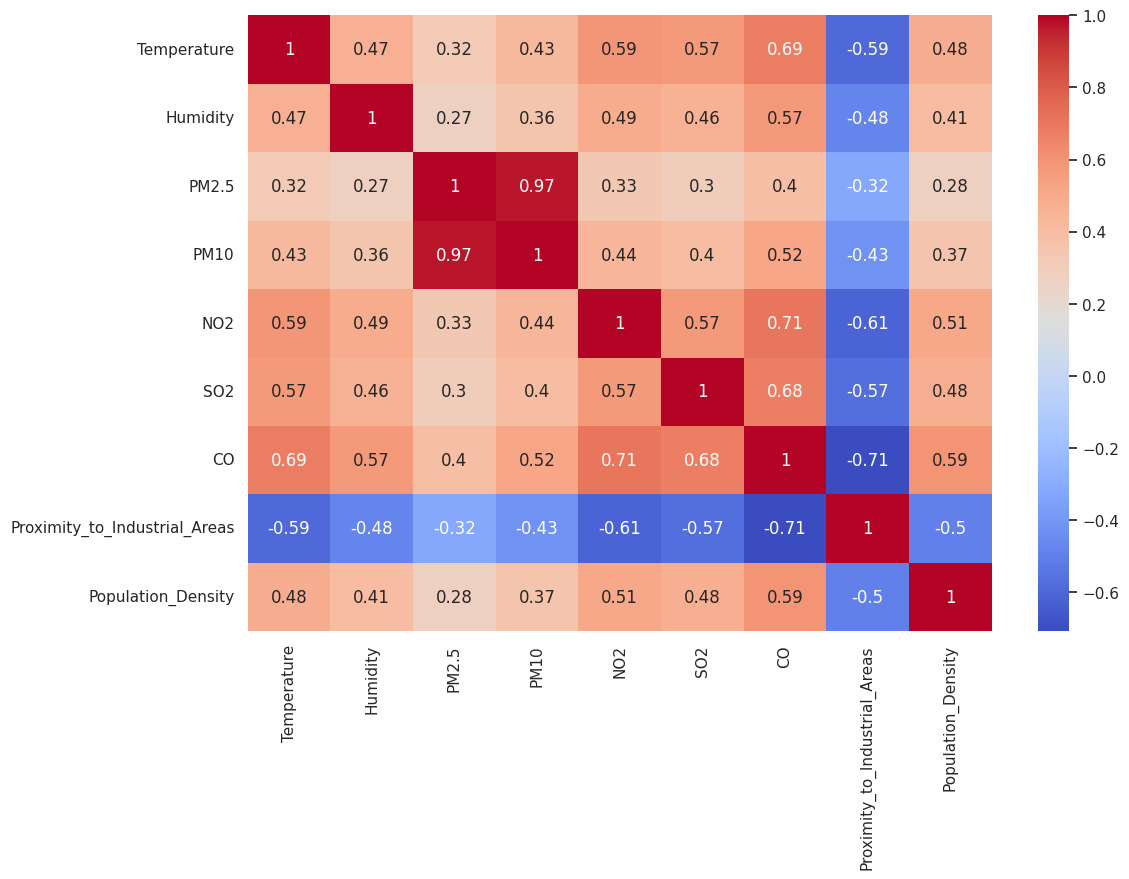

In [18]:
# correlation heatmap
corr = data[features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot = True,
    cmap = "coolwarm"
)
plt.show()



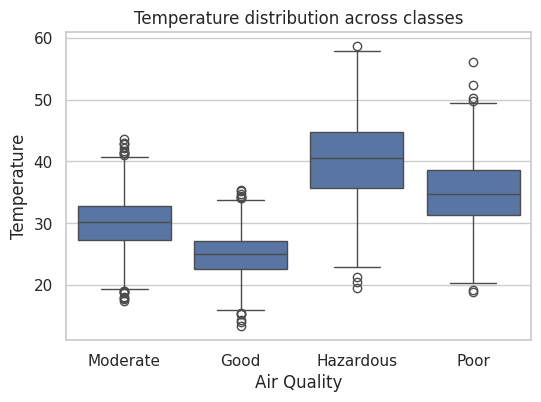

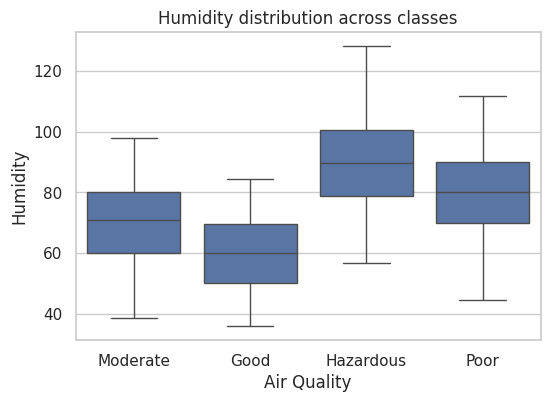

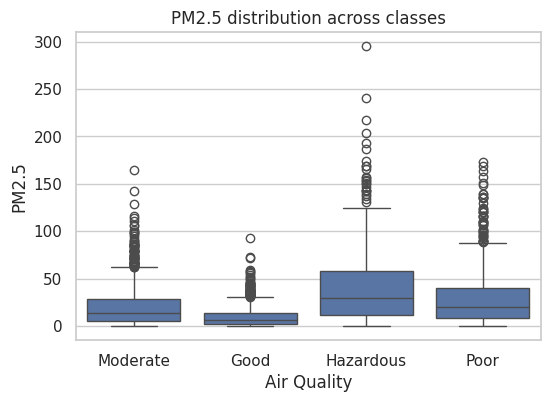

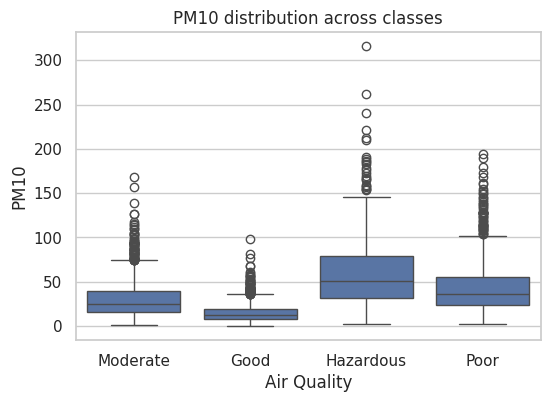

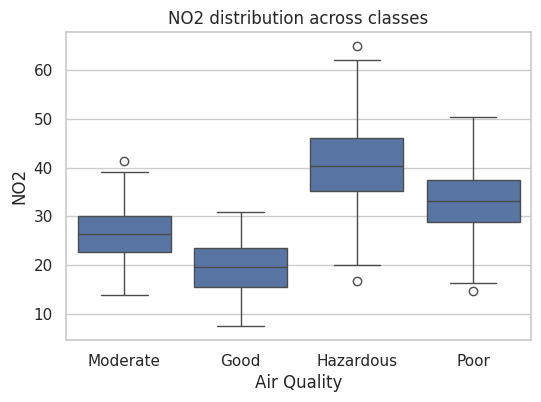

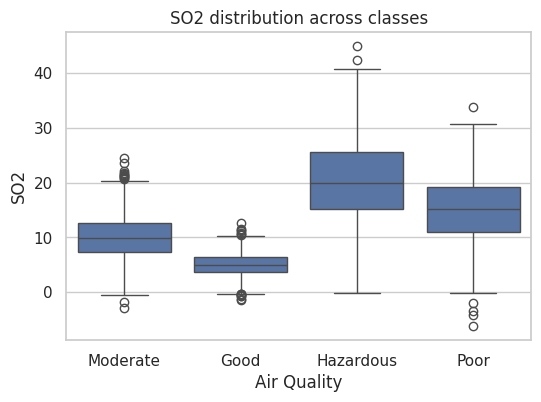

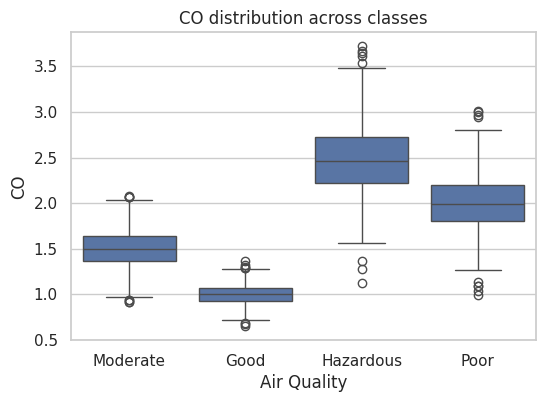

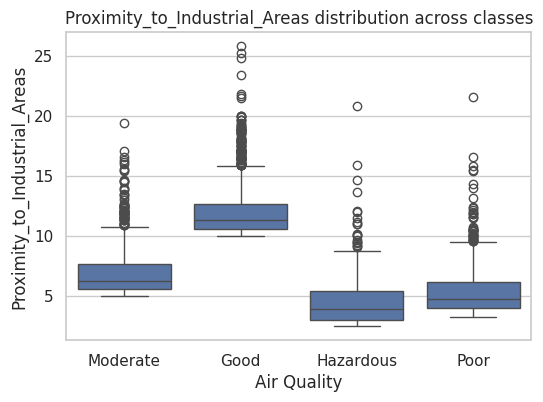

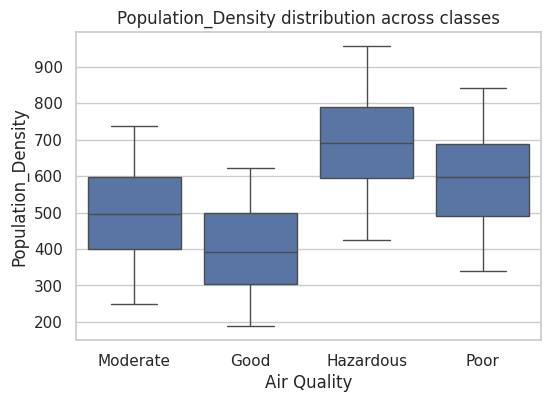

In [20]:

# boxplots per class
for feature in features:
  plt.figure(figsize=(6, 4))
  sns.boxplot(
      x = "Air Quality",
      y = feature,
      data = data
  )
  plt.title(f"{feature} distribution across classes")
  plt.show()

## data preprocessing

In [21]:
data.head(10)

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
5,39.4,96.6,14.6,35.5,42.9,17.9,1.82,3.1,674,Hazardous
6,41.7,82.5,1.7,15.8,31.1,12.7,1.80,4.6,735,Poor
7,31.0,59.6,5.0,16.8,24.2,13.6,1.38,6.3,443,Moderate
8,29.4,93.8,10.3,22.7,45.1,11.8,2.03,5.4,486,Poor
9,33.2,80.5,11.1,24.4,32.0,15.3,1.69,4.9,535,Poor


### pm2.5 and pm10 are highly correlated --> dropping pm10 to keep the fine grained pm2.5

In [22]:
data = data.drop("PM10", axis=1)
data.head(10)

,Temperature,Humidity,PM2.5,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,21.9,5.6,1.01,12.7,303,Good
5,39.4,96.6,14.6,42.9,17.9,1.82,3.1,674,Hazardous
6,41.7,82.5,1.7,31.1,12.7,1.80,4.6,735,Poor
7,31.0,59.6,5.0,24.2,13.6,1.38,6.3,443,Moderate
8,29.4,93.8,10.3,45.1,11.8,2.03,5.4,486,Poor
9,33.2,80.5,11.1,32.0,15.3,1.69,4.9,535,Poor


In [26]:
data["Air Quality"].value_counts()

,count
Air Quality,
Good,2000
Moderate,1500
Poor,1000
Hazardous,500


In [27]:
# encoding the air quality classes
encoder = LabelEncoder()
data["Air Quality"] = encoder.fit_transform(data["Air Quality"])
data["Air Quality"].value_counts()

,count
Air Quality,
0,2000
2,1500
3,1000
1,500


In [28]:
encoder.classes_

array(['Good', 'Hazardous', 'Moderate', 'Poor'], dtype=object)

In [31]:
# saving encoder
joblib.dump(encoder, "air_encoder.pkl")

['air_encoder.pkl']

## insights:
  - Good --> 0
  - Harzadous --> 1
  - Moderate --> 2
  - Poor --> 3


In [29]:
data.head(10)

,Temperature,Humidity,PM2.5,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,18.9,9.2,1.72,6.3,319,2
1,28.3,75.6,2.3,30.8,9.7,1.64,6.0,611,2
2,23.1,74.7,26.7,24.4,12.6,1.63,5.2,619,2
3,27.1,39.1,6.1,13.5,5.3,1.15,11.1,551,0
4,26.5,70.7,6.9,21.9,5.6,1.01,12.7,303,0
5,39.4,96.6,14.6,42.9,17.9,1.82,3.1,674,1
6,41.7,82.5,1.7,31.1,12.7,1.80,4.6,735,3
7,31.0,59.6,5.0,24.2,13.6,1.38,6.3,443,2
8,29.4,93.8,10.3,45.1,11.8,2.03,5.4,486,3
9,33.2,80.5,11.1,32.0,15.3,1.69,4.9,535,3


## features selection and train & test split

In [33]:
data.head()

,Temperature,Humidity,PM2.5,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,18.9,9.2,1.72,6.3,319,2
1,28.3,75.6,2.3,30.8,9.7,1.64,6.0,611,2
2,23.1,74.7,26.7,24.4,12.6,1.63,5.2,619,2
3,27.1,39.1,6.1,13.5,5.3,1.15,11.1,551,0
4,26.5,70.7,6.9,21.9,5.6,1.01,12.7,303,0


In [34]:
# feature and labels selection
X, y = data.drop("Air Quality", axis=1), data["Air Quality"]
X.head(10)

,Temperature,Humidity,PM2.5,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
0,29.8,59.1,5.2,18.9,9.2,1.72,6.3,319
1,28.3,75.6,2.3,30.8,9.7,1.64,6.0,611
2,23.1,74.7,26.7,24.4,12.6,1.63,5.2,619
3,27.1,39.1,6.1,13.5,5.3,1.15,11.1,551
4,26.5,70.7,6.9,21.9,5.6,1.01,12.7,303
5,39.4,96.6,14.6,42.9,17.9,1.82,3.1,674
6,41.7,82.5,1.7,31.1,12.7,1.80,4.6,735
7,31.0,59.6,5.0,24.2,13.6,1.38,6.3,443
8,29.4,93.8,10.3,45.1,11.8,2.03,5.4,486
9,33.2,80.5,11.1,32.0,15.3,1.69,4.9,535


In [37]:
y.head()

,Air Quality
0,2
1,2
2,2
3,0
4,0


In [44]:
X.shape

(5000, 8)

In [45]:
y.shape

(5000,)

In [38]:
# training and testing splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 21,
    stratify = y
)

In [39]:
print(X.shape, X_train.shape, X_test.shape)

(5000, 8) (4000, 8) (1000, 8)


## modelling, training, evaluation and tuning

### xgboost classifier

In [42]:
# model initialisation
xgb = XGBClassifier(
    n_estimators = 300,
    learning_rate = 0.01,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 21,
    eval_metric = "mlogloss"
)

In [46]:
# model training
xgb.fit(
    X_train, y_train
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [47]:
# predictions
xgb_pred = xgb.predict(X_test)

In [49]:
# evaluation metrics
acc = accuracy_score(
    y_test, xgb_pred
)
xgb_clf_report = classification_report(
    y_test,
    xgb_pred,
    target_names = encoder.classes_
)
print(f"xgboost classifier accuracy: {acc:.3f}")
print("xgboost classifier classification report:\n", xgb_clf_report)

xgboost classifier accuracy: 0.969
xgboost classifier classification report:
               precision    recall  f1-score   support

        Good       1.00      1.00      1.00       400
   Hazardous       0.98      0.93      0.95       100
    Moderate       0.95      0.98      0.96       300
        Poor       0.94      0.92      0.93       200

    accuracy                           0.97      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.97      0.97      1000

